# Construct postage stamps for PSF explanation #

Started 2016-07-07 (WIC)

**Purpose:** Flexibly cut out postage stamps around (faint, medium, bright) stars in an HLA image.

**Eventual learning goal:** Gain practice in understanding a regime where visual appearance of objects differs from our own everyday experience.

# Setup #

In [170]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table

In [171]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [172]:
from matplotlib import rcParams

In [173]:
plt.style.use('ggplot')

In [174]:
%matplotlib inline

In [175]:
rcParams['figure.figsize'] = (10, 12)

### Some control variables ###

In [176]:
# where are the image and star files located?
imgDir = os.getcwd()
txtDir = os.getcwd()

In [177]:
# image filename
imgFil = 'hlsp_heritage_hst_acs-wfc_m51_f435w_v1_drz_drz.fits'

In [178]:
# textfile with star coords. Comment "#" -- just x, y entries
txtFil = 'stars.txt'

# Load and examine image, stars #

In [179]:
imgPath = '%s/%s' % (imgDir, imgFil)
txtPath = '%s/%s' % (txtDir, txtFil)

In [180]:
# load the image
aImg = fits.getdata(imgPath)
print np.shape(aImg)

(12200, 8600)


In [213]:
# load the stars
tStars = Table.read(txtPath, format='ascii')
print tStars

  X      Y   
------ ------
6437.0 4960.0
6268.0 4821.0
6349.0 4823.0


### A little info for the plots ### 

In [230]:
# Some options
stampSz = [50,50]
constYrange = False
bigBright = False
readVertical = True
showTemplate = False # looks nice but doesn't show what you want it to show!

In [231]:
fig = plt.figure(1, figsize=(13,5))

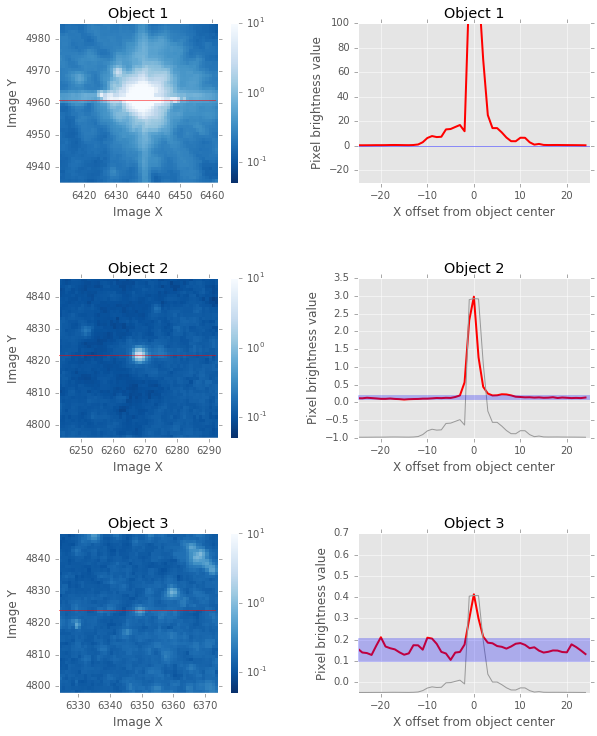

In [235]:
cmap = plt.cm.get_cmap('Blues_r')
plt.clf()

# colors for line and noise
cLine = 'r'
cNoise = 'b'

# give some space between the plots
if readVertical:
    plt.subplots_adjust(hspace=0.6, wspace=0.4)
else:
    plt.subplots_adjust(hspace=0.4, wspace=0.5)

# make the curves accessible to following loops
xCurves = []
yCurves = []
    
for iPatch in range(len(tStars)):

    # set the postage stamp array
    xc = tStars['X'][iPatch]
    yc = tStars['Y'][iPatch]
    
    # allow stampSz to vary
    sX = 0.5*np.copy(stampSz[0])
    sY = 0.5*np.copy(stampSz[1])
    
    if iPatch < 1 and bigBright:
        sX *= 2.8
        sY *= 2.8
    
    iLo = int(xc - sX)
    iHi = int(xc + sX)
    jLo = int(yc - sY)
    jHi = int(yc + sY)

    # take a cut through
    vCut = aImg[int(yc+1), iLo:iHi]
    lCut = np.arange(np.size(vCut))+iLo
    
    # postage stamp
    if readVertical:
        plt.subplot(len(tStars), 2, iPatch*2+1)
    else:
        plt.subplot(2, len(tStars), iPatch+1)    
    extent=[iLo, iHi, jLo, jHi]
    plt.imshow(aImg[jLo:jHi, iLo:iHi], \
               norm=LogNorm(), \
               interpolation='None', \
              cmap=cmap, vmin=0.05, vmax=10., origin='lower', zorder=1, \
              extent=extent)
    plt.plot(lCut, np.repeat(yc+1, np.size(lCut)), zorder=5 ,color=cLine, alpha=0.5)
    plt.xlim(iLo, iHi)
    plt.ylim(jLo, jHi)
    plt.xlabel('Image X')
    plt.ylabel('Image Y')
    plt.colorbar()
    plt.title('Object %i' % (iPatch+1))
    
    # spatial cut. Some awkwardness in the way the horizontal axis is defined
    if readVertical:
        plt.subplot(len(tStars), 2, iPatch*2+2)
    else:
        plt.subplot(2, len(tStars), iPatch + 1 + len(tStars))

    lww=1
    if showTemplate:
        lww=2
    plt.plot(lCut-xc, vCut, color=cLine, lw=lww)

    xCurves.append(lCut-xc)
    yCurves.append(vCut)
    
    # some custom limits to make this stand out a little better
    yLos = [-30., -1.0, -0.05]
    yHis = [100., 3.5, 0.7]
    
    if constYrange:
        yLos = np.repeat(0, 3)
        yHis = np.repeat(1.0,3)
    plt.ylim(yLos[iPatch], yHis[iPatch])
    plt.xlim(iLo-xc, iHi-xc)
    
    if showTemplate:
        if iPatch == 1:
            plt.plot(xCurves[0], yCurves[0]*0.03 - 1., color='0.6')
            
        if iPatch == 2:
            plt.plot(xCurves[0], yCurves[0]*0.0035 - 0.05, color='0.6')


        
    # filler for "noise" level
    alphaPoly = 0.25
    if iPatch < 1 and not constYrange:
        alphaPoly = 0.85
    xPoly = np.array([iLo, iHi, iHi, iLo, iLo])-xc
    yPoly = np.array([0.1, 0.1, 0.21, 0.21, 0.1])
    plt.fill(xPoly, yPoly, zorder=10, alpha=alphaPoly, color=cNoise)

    plt.xlabel('X offset from object center')
    plt.ylabel('Pixel brightness value')
    plt.title('Object %i' % (iPatch+1))

# save the figure to disk
plt.savefig('TEST_stamps.png')